In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## データの生成

$$
 x =  \sin(2 \pi f) + w
$$

$$
   y =  \text{step}(t<0.5) + w
$$


$$
    E[w] = 0,\quad  E[w^2] = \sigma^2    
$$

 
 
 

In [2]:
dt = 0.001 #[sec]
times  =  np.arange(0,1,dt)
N = times.shape[0]

f  = 5  #[Hz]
sigma  = 0.5

np.random.seed(1)
x_s =np.sin(2 * np.pi * times * f) 
x = x_s  +  sigma * np.random.randn(N)

y_s =  np.zeros(times.shape[0])
y_s[:times.shape[0]//2] = 1
y = y_s  +  sigma * np.random.randn(N)



In [3]:
#  時間と周波数のプロット
def plt_time_fft(x,times,title = ''):
    plt.figure(figsize=(10,3))
#     x - time plot
    plt.subplot(1,2,1)
    plt.plot(times,x)
    plt.title(title)
    plt.xlabel('Time[sec]')

    #     abs(X) - Freq plot
    plt.subplot(1,2,2)
    freq_X = np.fft.fftfreq(times.shape[0],times[1] - times[0])
    X = np.fft.fft(x)
    plt.plot(freq_X[:times.shape[0]//2], np.abs(X[:times.shape[0]//2]))
    plt.xlim([0,times.shape[0]//10])
    plt.xlabel('Frequency[Hz]')
    plt.savefig(title+'.png',pad_inches=0,bbox_inches='tight')

    

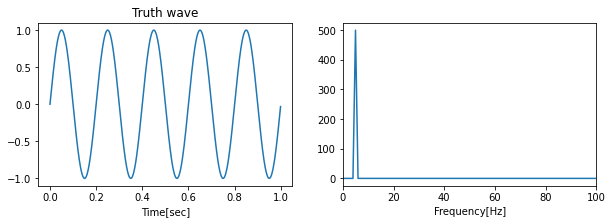

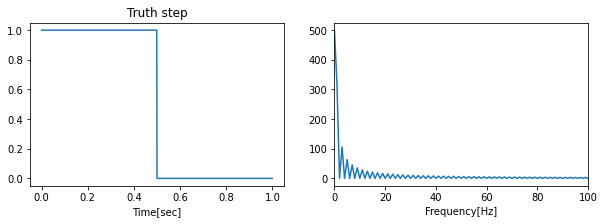

In [4]:
#   Truth  data
plt_time_fft(x_s,times,'Truth wave')
plt_time_fft(y_s,times,'Truth step')


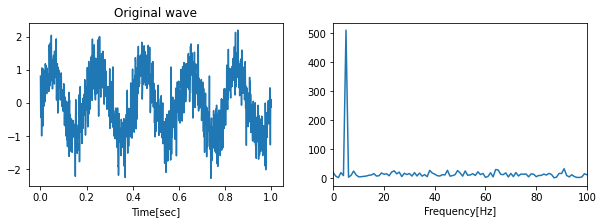

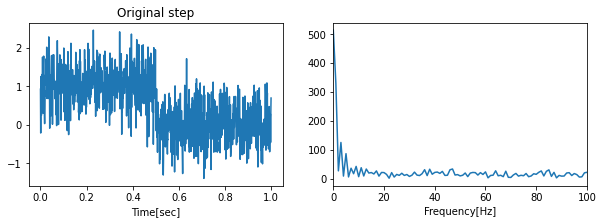

In [5]:
#  Original data = Truth + noise
plt_time_fft(x,times,'Original wave')
plt_time_fft(y,times,'Original step')


## 移動平均法 (Moving Average Method)

かんたんに設計できるが，精度は良くない．

- ハイパーパラメータ：

    tau :平均化するwindowサイズ[sec]．大きいほど，高周波数を除去する．

- その他：

    データ数が一致するように端点を処理．


In [6]:
def LPF_MAM(x,times,tau = 0.01):
    k = np.round(tau /(times[1] - times[0])).astype(int)
    x_mean =  np.zeros(x.shape)
    N = x.shape[0]
    for i in range(N):
        if  i-k//2 <0 :
            x_mean[i]  = x[: i - k//2 +k].mean()
        elif i - k//2 +k>=N:
            x_mean[i]  = x[i - k//2 :].mean()
        else :
            x_mean[i]  = x[i - k//2 : i - k//2 +k].mean()
    return x_mean

In [7]:
#  　真の分布を知っていると仮定して，  最適な設計
taus =  np.arange(0.001,0.1,0.001)
loss_x = np.zeros(taus.shape[0])
loss_y = np.zeros(taus.shape[0])

for i in range(taus.shape[0]):
    x_MAM = LPF_MAM(x,times,taus[i])
    y_MAM = LPF_MAM(y,times,taus[i])
    loss_x[i] =  np.linalg.norm(x_s - x_MAM)
    loss_y[i] =  np.linalg.norm(y_s - y_MAM)
    
tau_x = taus[np.argmin(loss_x)]
tau_y = taus[np.argmin(loss_y)]
x_MAM = LPF_MAM(x,times,tau_x)
y_MAM = LPF_MAM(y,times,tau_x)


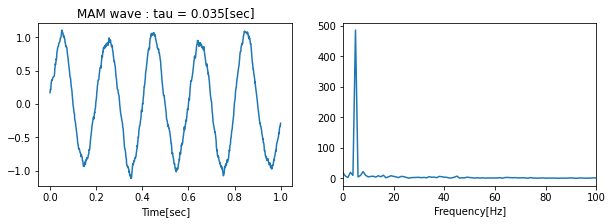

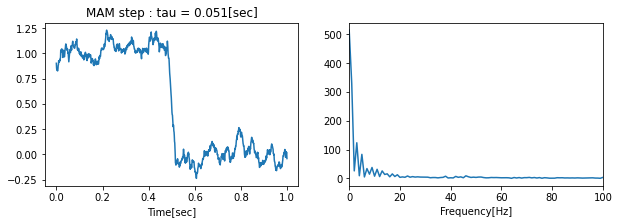

In [8]:
plt_time_fft(x_MAM,times,'MAM wave : tau = {0:.3f}[sec]'.format(tau_x))
plt_time_fft(y_MAM,times,'MAM step : tau = {0:.3f}[sec]'.format(tau_y))


## フーリエ変換+カットオフ

FFTをするので，データが増えると時間がかかる．
フーリエ変換後でカットオフされるので，ステップ型に弱い

- ハイパーパラメータ：

    fmax : cutoffする最大周波数[Hz]．　小さいほど，高周波数を除去する．



In [9]:
def  LPF_CF(x,times,fmax):
    freq_X = np.fft.fftfreq(times.shape[0],times[1] - times[0])
    X_F = np.fft.fft(x)
    X_F[freq_X>fmax] = 0
    X_F[freq_X<-fmax] = 0
#     虚数は削除
    x_CF  = np.fft.ifft(X_F).real    
    return x_CF


In [10]:
#  　真の分布を知っていると仮定して，  最適な設計
fmaxs =  np.arange(1,100,1)
loss_x = np.zeros(fmaxs.shape[0])
loss_y = np.zeros(fmaxs.shape[0])

for i in range(fmaxs.shape[0]):
    x_CF = LPF_CF(x,times,fmaxs[i])
    y_CF = LPF_CF(y,times,fmaxs[i])
    loss_x[i] =  np.linalg.norm(x_s - x_CF)
    loss_y[i] =  np.linalg.norm(y_s - y_CF)
    
fmax_x = fmaxs[np.argmin(loss_x)]
fmax_y = fmaxs[np.argmin(loss_y)]
x_CF = LPF_CF(x,times,fmax_x)
y_CF = LPF_CF(y,times,fmax_y)



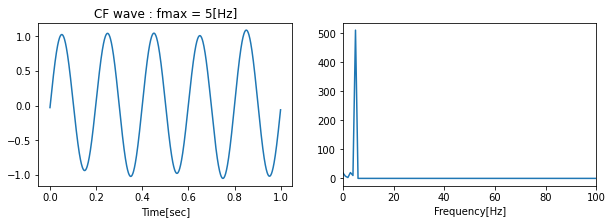

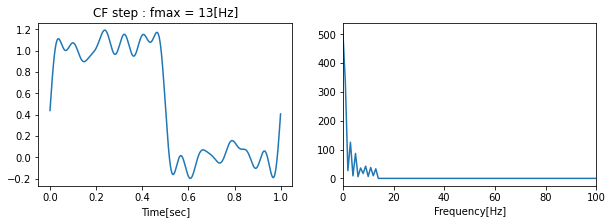

In [11]:
plt_time_fft(x_CF,times,'CF wave : fmax = {0}[Hz]'.format(fmax_x))
plt_time_fft(y_CF,times,'CF step : fmax = {0}[Hz]'.format(fmax_y))


## ガウス畳み込み

Windowサイズを大きく取る必要があるため，データ数が少ないと精度が悪い.

- ハイパーパラメータ：

    sigma:　畳み込みに用いるガウス分布の分散[sec]． 分散が大きいほど， 高周波を除去する．

- その他：

    データ数が一致するように端点を処理．


In [12]:
def  LPF_GC(x,times,sigma):
    sigma_k = sigma/(times[1]-times[0]) 
    kernel = np.zeros(int(round(3*sigma_k))*2+1)
    for i in range(kernel.shape[0]):
        kernel[i] =  1.0/np.sqrt(2*np.pi)/sigma_k * np.exp((i - round(3*sigma_k))**2/(- 2*sigma_k**2))
        
    kernel = kernel / kernel.sum()
    x_long = np.zeros(x.shape[0] + kernel.shape[0])
    x_long[kernel.shape[0]//2 :-kernel.shape[0]//2] = x
    x_long[:kernel.shape[0]//2 ] = x[0]
    x_long[-kernel.shape[0]//2 :] = x[-1]
        
    x_GC = np.convolve(x_long,kernel,'same')
    
    return x_GC[kernel.shape[0]//2 :-kernel.shape[0]//2]

In [13]:
#  　真の分布を知っていると仮定して，  最適な設計
sigmas =  np.arange(0.001,0.1,0.001)
loss_x = np.zeros(sigmas.shape[0])
loss_y = np.zeros(sigmas.shape[0])

for i in range(sigmas.shape[0]):
    x_GC = LPF_GC(x,times,sigmas[i])
    y_GC = LPF_GC(y,times,sigmas[i])
    loss_x[i] =  np.linalg.norm(x_s - x_GC)
    loss_y[i] =  np.linalg.norm(y_s - y_GC)
    
sigma_x = sigmas[np.argmin(loss_x)]
sigma_y = sigmas[np.argmin(loss_y)]
x_GC = LPF_GC(x,times,sigma_x)
y_GC = LPF_GC(y,times,sigma_y)



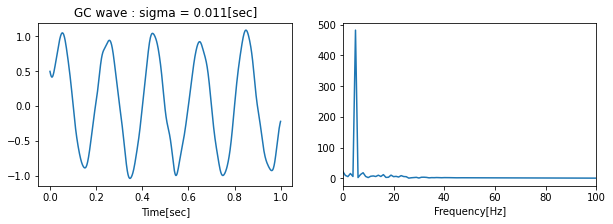

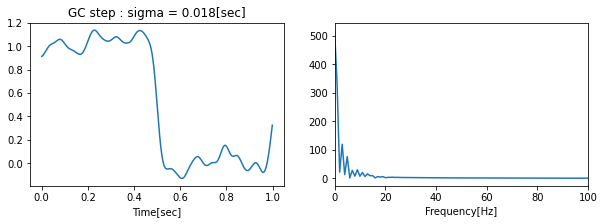

In [14]:
plt_time_fft(x_GC,times,'GC wave : sigma = {0:.3f}[sec]'.format(sigma_x))
plt_time_fft(y_GC,times,'GC step : sigma = {0:.3f}[sec]'.format(sigma_y))


##  一時遅れ系

 過去のデータのみを使ったローパスフィルタ．
 リアルタイムで更新したい場合に用いられる．
 
初期のバイアスがずれる
 

- ハイパーパラメータ：

    f_FO  :　時定数[sec]． 小さいほど， 高周波をカットする． 



In [15]:
def LPF_FO(x,times,f_FO=10):
    x_FO = np.zeros(x.shape[0])
    x_FO[0] = x[0]
    dt = times[1] -times[0]
    for i in range(times.shape[0]-1):
        x_FO[i+1] =  (1-  dt*f_FO) *x_FO[i]  + dt*f_FO* x[i]
    return x_FO


In [16]:
#  　真の分布を知っていると仮定して，  最適な設計

f_FOs =  np.arange(1,200,1)
loss_x = np.zeros(f_FOs.shape[0])
loss_y = np.zeros(f_FOs.shape[0])

for i in range(f_FOs.shape[0]):
    x_FO = LPF_FO(x,times,f_FOs[i])
    y_FO = LPF_FO(y,times,f_FOs[i])
    loss_x[i] =  np.linalg.norm(x_s  - x_FO - x_FO.mean())
    loss_y[i] =  np.linalg.norm(y_s - y_FO - x_FO.mean())
    
f_FO_x = f_FOs[np.argmin(loss_x)]
f_FO_y = f_FOs[np.argmin(loss_y)]
x_FO = LPF_FO(x,times,f_FO_x)
y_FO = LPF_FO(y,times,f_FO_y)



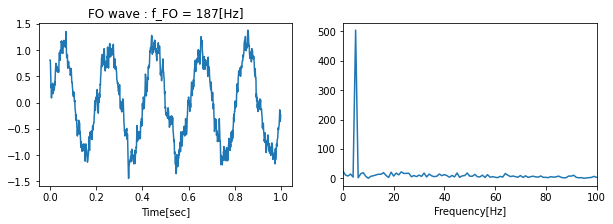

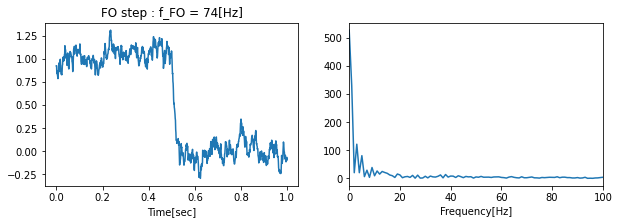

In [26]:
plt_time_fft(x_FO,times,'FO wave : f_FO = {0:.0f}[Hz]'.format(f_FO_x))
plt_time_fft(y_FO,times,'FO step : f_FO = {0:.0f}[Hz]'.format(f_FO_y))


## 補足: 畳み込みに行う関数


In [18]:
# MAM
k = np.round(tau_y /(times[1] - times[0])).astype(int)
kernel_MAM = np.zeros(times.shape[0])
kernel_MAM[times.shape[0]//2 - k//2 : times.shape[0] //2- k//2  + k ]= 1
kernel_MAM = kernel_MAM / kernel_MAM.sum()

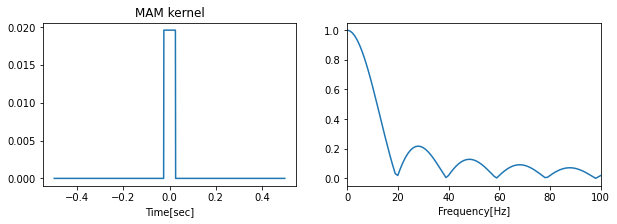

In [19]:
plt_time_fft(kernel_MAM,times-0.5,'MAM kernel')

In [20]:
# CF
freq_X = np.fft.fftfreq(times.shape[0],times[1] - times[0])
kernel_FC_fft = np.zeros(freq_X.shape[0])
kernel_FC_fft[np.abs(freq_X)<=fmax_y] = 1
kernel_FC = np.fft.ifft(kernel_FC_fft).real


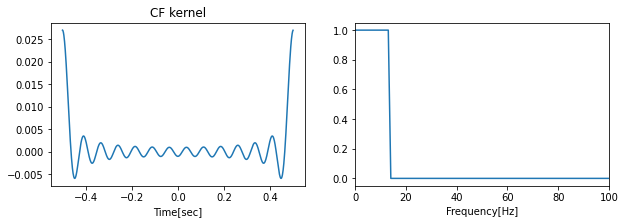

In [21]:
plt_time_fft(kernel_FC,times - 0.5, 'CF kernel')

In [22]:
# GC

sigma_k = sigma_y/(times[1]-times[0]) 
kernel = np.zeros(int(round(3*sigma_k))*2+1)
for i in range(kernel.shape[0]):
    kernel[i] =  1.0/np.sqrt(2*np.pi)/sigma_k * np.exp((i - round(3*sigma_k))**2/(- 2*sigma_k**2))

kernel = kernel / kernel.sum()

kernel_GC = np.zeros(times.shape[0])

kernel_GC[times.shape[0]//2 - kernel.shape[0]//2:times.shape[0]//2 - kernel.shape[0]//2 + kernel.shape[0]] = kernel

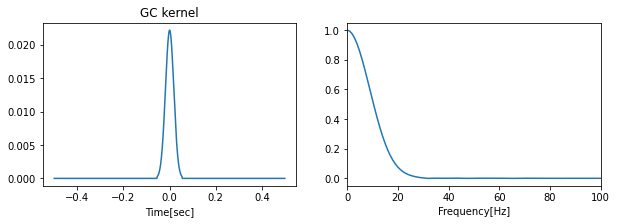

In [23]:
plt_time_fft(kernel_GC,times-0.5,'GC kernel')
# kernel_GC.shape

In [24]:
# FO
f_FO = 10
freq_X = np.fft.fftfreq(times.shape[0],times[1] - times[0])
kernel_FO_fft = np.zeros(freq_X.shape[0])
kernel_FO_fft = np.sqrt(f_FO**2 /(f_FO**2  + freq_X**2))
kernel_F0 = np.fft.ifft(kernel_FO_fft).real


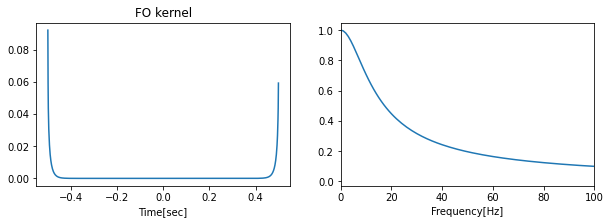

In [25]:
plt_time_fft(kernel_F0,times - 0.5, 'FO kernel')